<a href="https://colab.research.google.com/github/faithrts/ML-Intro/blob/main/supervised_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [ ]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import re
import math
import bisect
from scipy.stats import zscore
from scipy.io import arff
from importlib import reload

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as skl_train_test_split

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

# a folder to store the saved graphs
!mkdir images

# Data Handling

## Importing

In [ ]:
### importing the files from the web to google colab

# hepatitis.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data

# messidor_features.arff
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2022-10-11 00:01:09--  http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7545 (7.4K) [application/x-httpd-php]
Saving to: ‘hepatitis.data’

hepatitis.data      100%[===================>]   7.37K  --.-KB/s    in 0s      

2022-10-11 00:01:09 (672 MB/s) - ‘hepatitis.data’ saved [7545/7545]

--2022-10-11 00:01:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff’

messidor_features.a 100%[===================>] 114.48K   2

## Preprocessing

### Helper functions

In [ ]:
# replaces instances of '?' with the column's mean or mode
def imputation(df, bool_col, non_bool_col):
  copy_df = df.copy()

  # saves a copy of the dataframe without rows that include '?' values
  intact_rows = copy_df[~copy_df.eq('?').any(axis=1)].astype('float')

  # iterates through columns with boolean values
  for col in bool_col:

    # replaces instances of 1.0 and 2.0 with the boolean integers 0 and 1
    intact_rows[col] = intact_rows[col].replace({1.0:0, 2.0:1})
    # calculates the mode of the current column (ignores '?')
    mode = int(intact_rows[col].mode()[0])

    # in the original dataframe, replaces each '?' with the column's mode
    copy_df[col] = copy_df[col].replace({'?': mode}).astype('int64')
    # in the original dataframe, replaces 1.0 and 2.0 with boolean ints 0 and 1
    copy_df[col] = copy_df[col].replace({1.0:0, 2.0:1})

  # iterates through columns with non-boolean values
  for col in non_bool_col:
    # calculates the mean of the current column (ignores '?')
    mean = intact_rows[col].mean()
    # in the original dataframe, replaces each '?' with the column's mean
    copy_df[col] = copy_df[col].replace({'?': mean}).astype('float')
    
  return copy_df

In [ ]:
### computes zcore to remove outlier data
def remove_outliers(df):
  abs_z_scores = np.abs(df.apply(zscore))

  # a boolean array that returns True at index i if the row
  # i in df does not contain any values with a zscore greater
  # than 3
  instance_bool_arr = (abs_z_scores < 3).all(axis = 1)
  return df[instance_bool_arr]

In [ ]:
# normalizes an input array
def normalize_array(arr):
  normalized_array = []

  for i in arr:
    new_val = (i - min(arr)) / (max(arr) - min(arr))
    normalized_array.append(new_val)

  return normalized_array

# normalizes an input array
def normalize_2D_array(arr):
  normalized_2D_array = np.zeros(shape = arr.shape)

  for index in range(len(arr)):
    normalized_sub_arr = normalize_array(arr[index])
    normalized_2D_array[index] = normalized_sub_arr

  return normalized_2D_array

# normalizes columns in input dataframe df; 
# assumes last column is the target labels
def normalize_df(df):
  normalized_df = df.copy()

  for col in normalized_df.iloc[:, :-1]:
    normalized_col = normalize_array(df[col])
    normalized_df[col] = normalized_col

  return normalized_df

In [ ]:
def standardize_array(arr):
  standardized_array = []

  mean_val = arr.mean()
  standard_dev = arr.std()

  for i in arr:
    new_val = (i - mean_val) / standard_dev
    standardized_array.append(new_val)

  return standardized_array

def standardize_2D_array(arr):
  standardized_2D_array = np.zeros(shape = arr.shape)

  for index in range(len(arr)):
    standardized_sub_arr = standardize_array(arr[index])
    standardized_2D_array[index] = standardized_sub_arr

  return standardized_2D_array

# standardizes columns in input dataframe df;
# assumes last column is the target labels
def standardize_df(df):
  standardized_df = df.copy()

  # iterates through each column, excluding the last column
  for col in standardized_df.iloc[:, :-1]:

    # calculates mean value and standard deviation of column
    mean_val = standardized_df[col].mean()
    standard_dev = standardized_df[col].std()

    # standardizes the values in the current column
    standardized_df[col] = (standardized_df[col] - mean_val) / standard_dev

  return standardized_df

In [ ]:
# function to split the data;
# assumes the last column of the df is the target label
# and percentage_train is an integer out of 100
def train_test_split(df, percentage_train = 66):
  # makes a copy of the input df
  copy_df = df.copy()

  # shuffling the order of rows in the input dataframe
  copy_df = copy_df.sample(frac = 1, random_state = 1)

  # splits the input dataframe into arrays of instances and labels
  x, y = copy_df.iloc[:, :-1].to_numpy(), copy_df.iloc[:, -1].to_numpy()

  # the number of data points
  instance_count = x.shape[0]

  # the number of instances to be used in the training data
  train_count = int(instance_count * (percentage_train / 100))

  # splitting the data into training data and labels,
  # and testing data and labels
  x_train, y_train = x[:train_count], y[:train_count]
  x_test, y_test = x[train_count:], y[train_count:]

  return x_train, x_test, y_train, y_test

In [ ]:
# random forest for feature importance on a regression problem;
# assumes the first column is target labels
def RF_find_features(x_train, y_train, df):
  # splitting the data in the input dataframe df

  # define the model
  model = RandomForestRegressor()

  # fit the model
  model.fit(x_train, y_train)

  # the value at index i is the feature importance of the
  # feature at column i in the dataframe
  importance_arr = model.feature_importances_

  # summarize feature importance
  for i in range(len(importance_arr)):
      print('Feature: %-30sScore: %-12f' % (list(df.columns)[i], importance_arr[i]))

  return importance_arr

In [ ]:
# returns sorted arrays of the feature names and values
def find_top_features(importance_arr, df):
  # marks the indices that have already been checked
  found_indices = []

  # arrays for the sorted feature names and values
  sorted_important_feature_names = []
  sorted_important_feature_values = []

  # iterates through the inputted importance array
  for i in range(len(importance_arr)):
    # finds the top importance value that hasn't been seen yet
    top_feat_value = np.max([val for index, val in enumerate(importance_arr) if index not in found_indices])
    
    # saves the index of the top importance value that hasn't been seen yet and
    # appends it to the sorted array
    top_feat_index = importance_arr.tolist().index(top_feat_value)
    found_indices.append(top_feat_index)

    # finds the name of the feature with the top importance value that hasn't
    # been seen yet
    feature_name = list(df.columns)[top_feat_index]

    # saves the feature name of the top importance value that hasn't been seen yet and
    # appends it to the sorted array
    sorted_important_feature_names.append(feature_name)
    sorted_important_feature_values.append(top_feat_value)

  return sorted_important_feature_names, sorted_important_feature_values

#### Graphing functions

In [ ]:
# counts items in a given range
def count_in_ranges(item_arr, range_arr, bins = 10):
  count_arr = np.zeros(len(range_arr))

  for item in item_arr:
    pos = bisect.bisect_left(range_arr, item)
    count_arr[pos] += 1

  return count_arr

# creates histograms for each column in input dataframe df and array of columns
# column_arr
def create_histograms(df, column_arr = 0, n_cols = 3):
  # if no array of column names given, creates histograms for all columns
  if column_arr == 0:
    column_arr = list(df)

  # the number of rows
  n_rows = math.ceil(len(column_arr)/n_cols)

  # setting up a figure
  fig = plt.figure(figsize = (15, 9), tight_layout = True)

  # setting up space for graphs
  gs = gridspec.GridSpec(n_rows, n_cols)

  # setting current column and row numbers
  cur_col, cur_row = 0, 0

  # iterates through each column name
  for col in column_arr:

    mean = df[col].mean()

    if cur_col == n_cols:
      cur_col = 0
      cur_row += 1

    # plots histogram
    ax = fig.add_subplot(gs[cur_row, cur_col])
    ax.autoscale(True)
    ax.hist(df[col], color="#8ad07c")
    #ax.bar(range_arr, count_arr, width = 5)
    ax.set_title(col.upper())
    ax.set_xlabel("Value")
    ax.set_ylabel("Occurrence count")
    ax.axvline(x = mean, color = 'r', linestyle = '-', label = "Mean = " + str(round(mean, 2)))
    ax.legend(loc = "upper right")
    
    cur_col += 1

  plt.show()

In [ ]:
# plots feature importance
def plot_feature_importance(importance_arr):
  mean = importance_arr.mean()

  plt.bar([x for x in range(len(importance_arr))], importance_arr, color="#1363DF")
  plt.title("Feature importance")
  plt.xlabel("Feature index in data")
  plt.ylabel("Score")
  plt.axhline(y = mean, color = 'r', linestyle = '-', label = "Mean = " + str(round(mean, 2)))
  plt.legend(loc = "upper right")
  plt.show()

In [ ]:
# plots the distributions of boolean feature values
def plot_bool_distributions(column_arr, df, n_cols = 3):
  # the number of rows
  n_rows = math.ceil(len(column_arr)/n_cols)

  # setting up a figure
  fig = plt.figure(figsize = (15, 9), tight_layout = True)

  # setting up space for graphs
  gs = gridspec.GridSpec(n_rows, n_cols)

  # setting current column and row numbers
  cur_col, cur_row = 0, 0
  
  for col in column_arr:
    x_arr = ['True', 'False']
    y_arr = np.bincount(df[col].to_numpy())

    if cur_col == n_cols:
      cur_col = 0
      cur_row += 1

    # plots histogram
    ax = fig.add_subplot(gs[cur_row, cur_col])
    ax.autoscale(True)
    ax.bar(x_arr, y_arr, color='#AFB4FF')
    ax.set_title(col.upper())
    ax.set_xlabel("Value")
    ax.set_ylabel("Instance count")

    bar_num = 0

    for bar in ax.patches:
      percentage = round((y_arr[bar_num]/y_arr.sum()), 2) * 100

      w = bar.get_width()
      h = bar.get_height()
      x, y = bar.get_xy()
      plt.text(x + w/2, y + h*1.01, str(percentage) + '%', ha = 'center')
      
      bar_num += 1

    cur_col += 1

  plt.show()

### Loading and cleaning hepatitis.data

In [ ]:
### creating the dataframe for hepatitis.data

# creates a dataframe from the .data file
hep_df = pd.read_csv("hepatitis.data", sep=",", header=None)

# the column names
hep_cols = ['CLASS', 'AGE', 'SEX', 'STEROID','ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN',
            'PROTIME', 'HISTOLOGY']

# adds the column names to the dataframe
hep_df.columns = hep_cols

In [ ]:
### creating lists to separate the names of columns containing
### boolean values vs the ones containing continuous values

bool_col = ['CLASS', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'HISTOLOGY']

non_bool_col = ['AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']

In [ ]:
### cleaning hepatitis dataframe

# moves the target "CLASS" column to the end of the dataframe
class_col = hep_df.pop('CLASS')
hep_df['CLASS'] = class_col

# saves a copy of the dataframe cleaned through imputation
hep_imp_df = imputation(hep_df, bool_col, non_bool_col)

# removes all rows with ?
hep_df = hep_df[~hep_df.eq('?').any(axis=1)].astype('float')

# maps all 1.0 values to 0 and all 2.0 values to 1
for col in bool_col:
  hep_df[col] = hep_df[col].replace({1.0:0, 2.0:1}).astype('int')

In [ ]:
hep_imp_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
0,30.0,1,0,1,1,1,1,0,1,1,1,1,1,1.0,85.0000,18.0,4.0,62.5125,0,1
1,50.0,0,0,1,0,1,1,0,1,1,1,1,1,0.9,135.0000,42.0,3.5,62.5125,0,1
2,78.0,0,1,1,0,1,1,1,1,1,1,1,1,0.7,96.0000,32.0,4.0,62.5125,0,1
3,31.0,0,0,0,1,1,1,1,1,1,1,1,1,0.7,46.0000,52.0,4.0,80.0000,0,1
4,34.0,0,1,1,1,1,1,1,1,1,1,1,1,1.0,102.9125,200.0,4.0,62.5125,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46.0,0,1,1,0,0,0,1,1,1,0,0,0,7.6,102.9125,242.0,3.3,50.0000,1,0
151,44.0,0,1,1,0,1,1,1,0,1,1,1,1,0.9,126.0000,142.0,4.3,62.5125,1,1
152,61.0,0,0,1,0,0,1,0,0,1,0,1,1,0.8,75.0000,20.0,4.1,62.5125,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0000,19.0,4.1,48.0000,1,1


In [ ]:
hep_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
5,34.0,0,1,1,1,1,1,1,1,1,1,1,1,0.9,95.0,28.0,4.0,75.0,0,1
10,39.0,0,0,0,1,1,1,0,0,1,1,1,1,1.3,78.0,30.0,4.4,85.0,0,1
11,32.0,0,1,0,0,1,1,1,0,1,0,1,1,1.0,59.0,249.0,3.7,54.0,0,1
12,41.0,0,1,0,0,1,1,1,0,1,1,1,1,0.9,81.0,60.0,3.9,52.0,0,1
13,30.0,0,1,1,0,1,1,1,0,1,1,1,1,2.2,57.0,144.0,4.9,78.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,45.0,0,1,0,1,1,1,1,1,1,1,1,1,1.3,85.0,44.0,4.2,85.0,1,1
143,49.0,0,0,1,0,0,1,1,1,0,0,1,1,1.4,85.0,70.0,3.5,35.0,1,0
145,31.0,0,0,1,0,1,1,1,1,1,1,1,1,1.2,75.0,173.0,4.2,54.0,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0,19.0,4.1,48.0,1,1


In [ ]:
# uses zscore to remove outliers 
# (rows with values above 3 standard deviations beyond the respective column means)
hep_df = remove_outliers(hep_df)
hep_imp_df = remove_outliers(hep_imp_df)

In [ ]:
# the data cleaned with imputation without the outliers
hep_imp_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
0,30.0,1,0,1,1,1,1,0,1,1,1,1,1,1.0,85.0000,18.0,4.0,62.5125,0,1
1,50.0,0,0,1,0,1,1,0,1,1,1,1,1,0.9,135.0000,42.0,3.5,62.5125,0,1
2,78.0,0,1,1,0,1,1,1,1,1,1,1,1,0.7,96.0000,32.0,4.0,62.5125,0,1
3,31.0,0,0,0,1,1,1,1,1,1,1,1,1,0.7,46.0000,52.0,4.0,80.0000,0,1
4,34.0,0,1,1,1,1,1,1,1,1,1,1,1,1.0,102.9125,200.0,4.0,62.5125,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,36.0,0,1,1,1,1,1,1,1,1,1,1,1,0.6,120.0000,30.0,4.0,62.5125,1,1
151,44.0,0,1,1,0,1,1,1,0,1,1,1,1,0.9,126.0000,142.0,4.3,62.5125,1,1
152,61.0,0,0,1,0,0,1,0,0,1,0,1,1,0.8,75.0000,20.0,4.1,62.5125,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0000,19.0,4.1,48.0000,1,1


In [ ]:
# the data without the outliers
hep_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
5,34.0,0,1,1,1,1,1,1,1,1,1,1,1,0.9,95.0,28.0,4.0,75.0,0,1
10,39.0,0,0,0,1,1,1,0,0,1,1,1,1,1.3,78.0,30.0,4.4,85.0,0,1
11,32.0,0,1,0,0,1,1,1,0,1,0,1,1,1.0,59.0,249.0,3.7,54.0,0,1
12,41.0,0,1,0,0,1,1,1,0,1,1,1,1,0.9,81.0,60.0,3.9,52.0,0,1
13,30.0,0,1,1,0,1,1,1,0,1,1,1,1,2.2,57.0,144.0,4.9,78.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,45.0,0,1,0,1,1,1,1,1,1,1,1,1,1.3,85.0,44.0,4.2,85.0,1,1
143,49.0,0,0,1,0,0,1,1,1,0,0,1,1,1.4,85.0,70.0,3.5,35.0,1,0
145,31.0,0,0,1,0,1,1,1,1,1,1,1,1,1.2,75.0,173.0,4.2,54.0,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0,19.0,4.1,48.0,1,1


In [ ]:
### saving train/test splits for different versions of hepatitis data

# for the whole hepatitis dataframe
x_train_hep, x_test_hep, y_train_hep, y_test_hep = train_test_split(hep_df)

# for the hepatitis dataframe cleaned through imputation
x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp = train_test_split(hep_imp_df)

### Analysis of Hepatitis data

In [ ]:
### finding the most correlated features with CLASS column (target)

# creates correlation dataframe
correlation_df = hep_df.corr()

# isolates for the CLASS column of the correlation dataframe and removes
# the CLASS row
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
hep_pos_cor = pos_correlation.head()

# saving the most positively correlated feature
hep_most_pos_cor = hep_pos_cor.index[0]

pos_correlation.head()

,CLASS
ALBUMIN,0.393190
ASCITES,0.367521
PROTIME,0.328634


In [ ]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
hep_neg_cor = neg_correlation.head()

# saving the most negatively correlated feature
hep_most_neg_cor = hep_neg_cor.index[0]

neg_correlation.head()

,CLASS
HISTOLOGY,-0.463524
LIVER BIG,-0.171780
AGE,-0.165716


In [ ]:
# variance of hepatitis data

print("Variance of each feature\n")
hep_df.var()

Variance of each feature



AGE                 128.929471
SEX                   0.118475
STEROID               0.251759
ANTIVIRALS            0.199926
FATIGUE               0.238430
MALAISE               0.226768
ANOREXIA              0.128286
LIVER BIG             0.146797
LIVER FIRM            0.250463
SPLEEN PALPABLE       0.155498
SPIDERS               0.211773
ASCITES               0.108293
VARICES               0.086820
BILIRUBIN             0.288280
ALK PHOSPHATE      2371.586079
SGOT               3309.675861
ALBUMIN               0.288760
PROTIME             546.480007
HISTOLOGY             0.241577
CLASS                 0.108293
dtype: float64

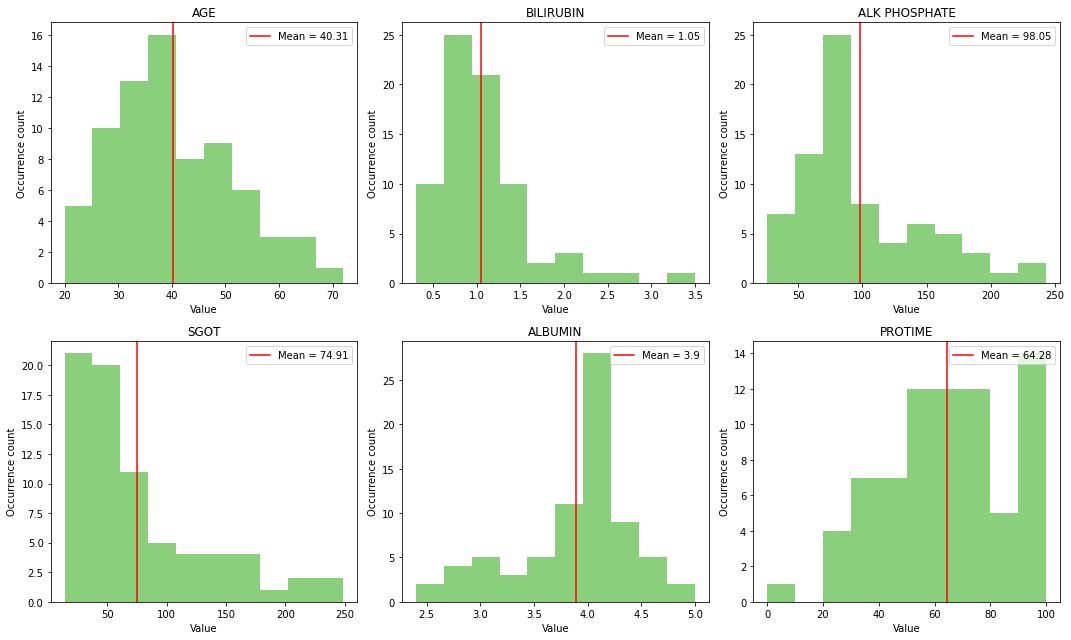

In [ ]:
# outputs histograms of the non-boolean columns
create_histograms(hep_df, non_bool_col, 3)

Feature: AGE                           Score: 0.067645    
Feature: SEX                           Score: 0.008318    
Feature: STEROID                       Score: 0.005572    
Feature: ANTIVIRALS                    Score: 0.000000    
Feature: FATIGUE                       Score: 0.001115    
Feature: MALAISE                       Score: 0.010342    
Feature: ANOREXIA                      Score: 0.018890    
Feature: LIVER BIG                     Score: 0.003280    
Feature: LIVER FIRM                    Score: 0.000000    
Feature: SPLEEN PALPABLE               Score: 0.012754    
Feature: SPIDERS                       Score: 0.005016    
Feature: ASCITES                       Score: 0.017453    
Feature: VARICES                       Score: 0.016401    
Feature: BILIRUBIN                     Score: 0.137151    
Feature: ALK PHOSPHATE                 Score: 0.110835    
Feature: SGOT                          Score: 0.040290    
Feature: ALBUMIN                       Score: 0.102636  

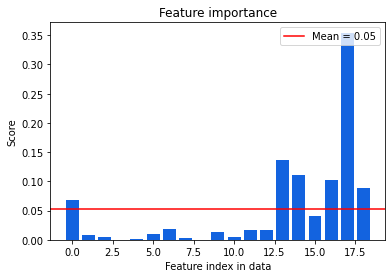

In [ ]:
### using random forest to determine the relative feature importance

hep_importance_arr = RF_find_features(x_train_hep, y_train_hep, hep_df)

# plots the feature importance
plot_feature_importance(hep_importance_arr)

In [ ]:
### finding the top 2 RF important features to confirm values in correlation dataframe

hep_sorted_feature_names, hep_sorted_feature_values = find_top_features(hep_importance_arr, hep_df)

hep_top_feat_RF = hep_sorted_feature_names[0]
hep_sec_feat_RF = hep_sorted_feature_names[1]

print("The most important feature is " + hep_top_feat_RF)
print("The second most important feature is " + hep_sec_feat_RF)

The most important feature is PROTIME
The second most important feature is BILIRUBIN


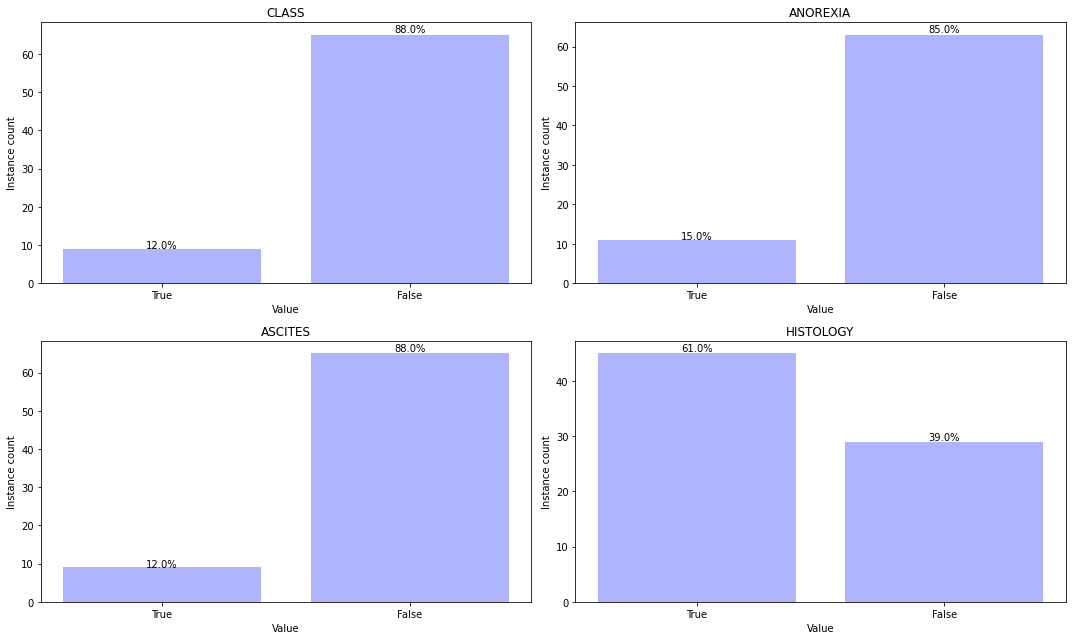

In [ ]:
### analysis of boolean distributions for CLASS, ANOREXIA, ASCITES, HISTOLOGY

# chose these columns by finding the boolean-valued features with the highest
# RF importances (except Class, is the labels)
bool_cols_of_interest = ['CLASS', 'ANOREXIA', 'ASCITES', 'HISTOLOGY']

# plotting a bar graph for each boolean column of interest
plot_bool_distributions(bool_cols_of_interest, hep_df, 2)

### Loading and cleaning messidor.arff

In [ ]:
### creating the dataframe for messidor_features.arff

# loads in the arff data
mess_data = arff.loadarff('messidor_features.arff')
# creates a dataframe from the .arff file
mess_df = pd.DataFrame(mess_data[0])

# the column names
mess_cols = ['QUALITY ASSESSMENT', 'PRE-SCREENING', 'MA DETECTION CL 0.5',
            'MA DETECTION CL 0.6','MA DETECTION CL 0.7', 'MA DETECTION CL 0.8',
            'MA DETECTION CL 0.9','MA DETECTION CL 1.0',
            'EXUDATES CL 0.5', 'EXUDATES CL 0.57','EXUDATES CL 0.64',
            'EXUDATES CL 0.71', 'EXUDATES CL 0.79','EXUDATES CL 0.86',
            'EXUDATES CL 0.93', 'EXUDATES CL 1.00', 'MACULA-OPTIC DISC DISTANCE', 'OPTIC DISC DIAMATER', 
            'AM/FM CLASSIFICATION', 'CLASS']

# adds the column names to the dataframe
mess_df.columns = mess_cols

In [ ]:
### cleaning the data in mess_df; there's no missing data so no imputation

# resaving the boolean values in the Class column from objects to ints
mess_df['CLASS'] = mess_df['CLASS'].map({b'0':0, b'1':1})

# columns with boolean values
mess_bool_cols = ['QUALITY ASSESSMENT', 'PRE-SCREENING', 'AM/FM CLASSIFICATION', 'CLASS']

# ensures the columns with boolean values save as integers
for col in mess_bool_cols:
  mess_df[col] = mess_df[col].astype('int64')

In [ ]:
mess_df

,QUALITY ASSESSMENT,PRE-SCREENING,MA DETECTION CL 0.5,MA DETECTION CL 0.6,MA DETECTION CL 0.7,MA DETECTION CL 0.8,MA DETECTION CL 0.9,MA DETECTION CL 1.0,EXUDATES CL 0.5,EXUDATES CL 0.57,EXUDATES CL 0.64,EXUDATES CL 0.71,EXUDATES CL 0.79,EXUDATES CL 0.86,EXUDATES CL 0.93,EXUDATES CL 1.00,MACULA-OPTIC DISC DISTANCE,OPTIC DISC DIAMATER,AM/FM CLASSIFICATION,CLASS
0,1,1,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1,1,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1148,1,0,49.0,48.0,48.0,45.0,43.0,33.0,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,0
1149,1,1,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [ ]:
# uses zscore to remove outliers 
# (rows with values above 3 standard deviations beyond the respective column means)
mess_df = remove_outliers(mess_df)

In [ ]:
# the data without the outliers
mess_df

,QUALITY ASSESSMENT,PRE-SCREENING,MA DETECTION CL 0.5,MA DETECTION CL 0.6,MA DETECTION CL 0.7,MA DETECTION CL 0.8,MA DETECTION CL 0.9,MA DETECTION CL 1.0,EXUDATES CL 0.5,EXUDATES CL 0.57,EXUDATES CL 0.64,EXUDATES CL 0.71,EXUDATES CL 0.79,EXUDATES CL 0.86,EXUDATES CL 0.93,EXUDATES CL 1.00,MACULA-OPTIC DISC DISTANCE,OPTIC DISC DIAMATER,AM/FM CLASSIFICATION,CLASS
0,1,1,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,1,1,35.0,34.0,33.0,33.0,33.0,26.0,2.579859,0.001552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537551,0.124181,0,0
1146,1,1,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1149,1,1,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [ ]:
# creating the training and testing data and labels for the messidor dataframe
x_train_mess, x_test_mess, y_train_mess, y_test_mess = train_test_split(mess_df)

### Analysis of Messidor Features

In [ ]:
### finding the most correlated features with Class column (target)

# creates correlation dataframe
correlation_df = mess_df.corr()

# removes the first row of the correlation dataframe
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
mess_pos_cor = pos_correlation.head()

# saving the most positively correlated feature
mess_most_pos_cor = mess_pos_cor.index[0]

pos_correlation.head()

,CLASS
MA DETECTION CL 0.5,0.282618
MA DETECTION CL 0.6,0.254831
MA DETECTION CL 0.7,0.224684


In [ ]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
mess_neg_cor = neg_correlation.head()

# saving the most positively correlated feature
mess_most_neg_cor = mess_neg_cor.index[0]

neg_correlation.head()

,CLASS
EXUDATES CL 0.57,-0.064864
EXUDATES CL 0.64,-0.030217
AM/FM CLASSIFICATION,-0.023560


In [ ]:
# variance of messidor data

print("Variance of each feature\n")
mess_df.var()

Variance of each feature



QUALITY ASSESSMENT               0.000000
PRE-SCREENING                    0.000000
MA DETECTION CL 0.5            585.474694
MA DETECTION CL 0.6            527.183070
MA DETECTION CL 0.7            484.530497
MA DETECTION CL 0.8            426.105853
MA DETECTION CL 0.9            373.551667
MA DETECTION CL 1.0            224.233686
EXUDATES CL 0.5               2358.982640
EXUDATES CL 0.57               290.073147
EXUDATES CL 0.64                66.792922
EXUDATES CL 0.71                 3.457284
EXUDATES CL 0.79                 0.485118
EXUDATES CL 0.86                 0.068840
EXUDATES CL 0.93                 0.015424
EXUDATES CL 1.00                 0.003338
MACULA-OPTIC DISC DISTANCE       0.000732
OPTIC DISC DIAMATER              0.000272
AM/FM CLASSIFICATION             0.217914
CLASS                            0.250257
dtype: float64

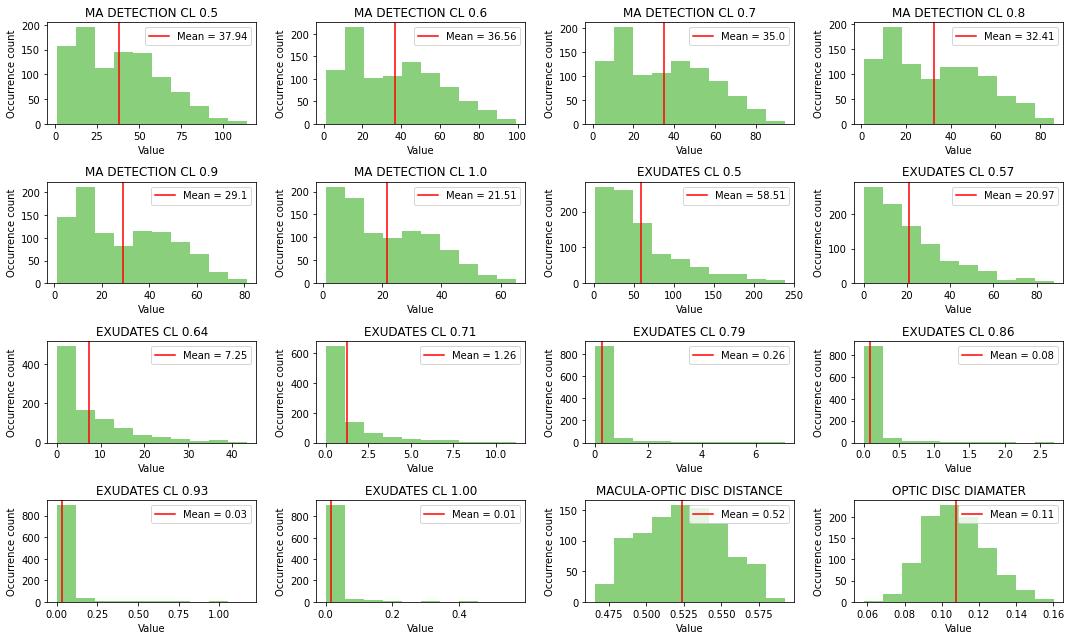

In [ ]:
### creating histograms for each non-boolean valued column

create_histograms(mess_df, list(mess_df)[2:18], 4)

Feature: QUALITY ASSESSMENT            Score: 0.000000    
Feature: PRE-SCREENING                 Score: 0.000000    
Feature: MA DETECTION CL 0.5           Score: 0.137176    
Feature: MA DETECTION CL 0.6           Score: 0.023931    
Feature: MA DETECTION CL 0.7           Score: 0.024198    
Feature: MA DETECTION CL 0.8           Score: 0.030962    
Feature: MA DETECTION CL 0.9           Score: 0.033448    
Feature: MA DETECTION CL 1.0           Score: 0.045251    
Feature: EXUDATES CL 0.5               Score: 0.092984    
Feature: EXUDATES CL 0.57              Score: 0.083530    
Feature: EXUDATES CL 0.64              Score: 0.076304    
Feature: EXUDATES CL 0.71              Score: 0.080756    
Feature: EXUDATES CL 0.79              Score: 0.041967    
Feature: EXUDATES CL 0.86              Score: 0.031220    
Feature: EXUDATES CL 0.93              Score: 0.080380    
Feature: EXUDATES CL 1.00              Score: 0.027574    
Feature: MACULA-OPTIC DISC DISTANCE    Score: 0.088167  

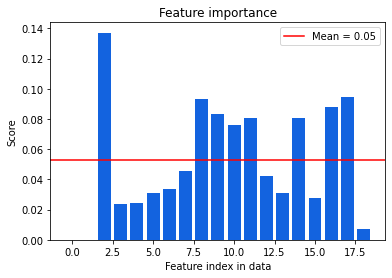

In [ ]:
### using random forest to determine the relative feature importance

mess_importance_arr = RF_find_features(x_train_mess, y_train_mess, mess_df)

# plots the feature importance
plot_feature_importance(mess_importance_arr)

In [ ]:
### finding the top 2 RF important features to check values in correlation dataframe

mess_sorted_feature_names, mess_sorted_feature_values = find_top_features(mess_importance_arr, mess_df)

mess_top_feat_RF = mess_sorted_feature_names[0]
mess_sec_feat_RF = mess_sorted_feature_names[1]

print("The most important feature is " + mess_top_feat_RF)
print("The second most important feature is " + mess_sec_feat_RF)

The most important feature is MA DETECTION CL 0.5
The second most important feature is OPTIC DISC DIAMATER


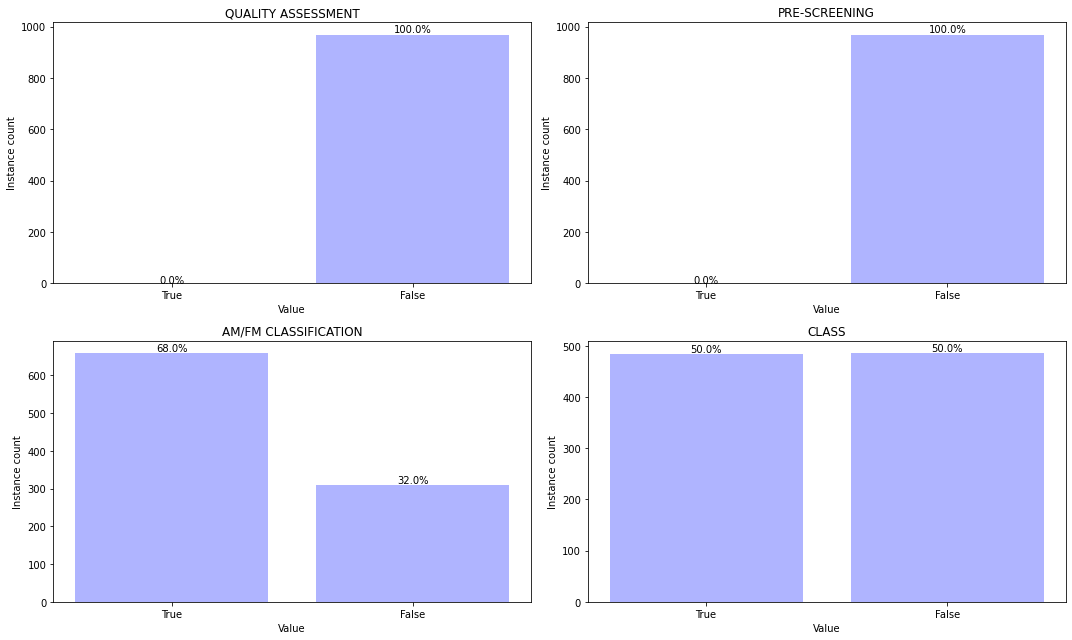

In [ ]:
#### plotting a bar graph for each boolean column
plot_bool_distributions(mess_bool_cols, mess_df, 2)

# Implementing models

## Helper functions

In [ ]:
### accuracy-evaluating function
def evaluate_acc(true_labels, target_labels):

  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances
  # divided by the total amount
  accuracy = np.sum(target_labels == true_labels)/label_count

  return accuracy

In [ ]:

def plot_KNN(knn_model, class_pred, x_train, x_test, y_train, y_test, feature_names, filename = ''):
    correct_pred = class_pred == y_test
    incorrect_pred = np.logical_not(correct_pred)

    _, knn_arr = knn_model.predict(x_test)

    # plots the data in a scatter plot
    plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
    plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
    plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

    # creates lines from data points to nearest neighbours
    for i in range(x_test.shape[0]):
      for k in range(knn_model.K):
        hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
        ver = x_test[i, 1], x_train[knn_arr[i, k], 1]
        plt.plot(hor, ver, 'k-', alpha = 0.1)

    # labels the scatter plot accordingly and displays it
    if(feature_names == 0):
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
    else:
      plt.xlabel(feature_names[0])
      plt.ylabel(feature_names[1])

    plt.legend()
    plt.show()

    # saving the graph if a filename was passed as input
    if len(filename) != 0:
      plt.savefig('images/' + filename + '.png', dpi=300, bbox_inches='tight')

def run_KNN(x_train, x_test, y_train, y_test, feature_names = 0, K_val = 3, function = 0, silent = False, filename = ''):
  if function == 0:
    # creates a new KNN model
    knn_model = KNN(K = K_val)
  elif function in [euclidean, manhattan, cosine]:
    # creates a new KNN model
    knn_model = KNN(K = K_val, dist_fn = function)
  else:
    return

  # fits the model to the training data
  knn_model = knn_model.fit(x_train, y_train)

  # tests the model on the testing data and the training data
  class_prob, _ = knn_model.predict(x_test)
  train_class_prob, _ = knn_model.predict(x_train)

  # creates arrays of the most likely class labels for each instance
  class_pred = np.argmax(class_prob, axis = -1)
  train_pred = np.argmax(train_class_prob, axis = -1)

  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)
  train_accuracy = evaluate_acc(y_train, train_pred)

  # creates boolean arrays to represent correct and incorrect predictions
  correct_pred = class_pred == y_test
  incorrect_pred = np.logical_not(correct_pred)

  if not silent:
    print("The accuracy of the model on the training data: " + str(round((train_accuracy * 100), 2)) + "%") #
    print("The accuracy of the model on the testing data: " + str(round((accuracy * 100), 2)) + "%")

  # if the data is based on two features
  if x_train.shape[1] == 2:
    plot_KNN(knn_model, class_pred, x_train, x_test, y_train, y_test, feature_names, filename)

  return accuracy, train_accuracy

In [ ]:
def plot_DT_DB(x, y, x_train, x_test, y_train, y_test, feature_names = 0, filename = ''):

  #we can make the grid finer by increasing the number of samples from 200 to higher value
  x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
  x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

  # to features values as a mesh  
  x0, x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  #Number of classes:
  C = np.max(y)+1

  # Getting coloring for y
  y_train_prob = np.zeros((y_train.shape[0], C))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  model = DecisionTree(max_depth = 10, cost_fn = gini_cost)

  y_prob_all = model.fit(x_train, y_train).predict(x_all)
  y_pred_all = np.argmax(y_prob_all, axis = -1)

  # graphing the results
  scatter = plt.scatter(x_train[:,0], x_train[:,1], c = y_train, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c = y_pred_all, marker='.', alpha=.01)

  plt.legend(*scatter.legend_elements(), title="Class")

  if(feature_names == 0):
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
  else:
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])

  # saving the graph if a filename was passed as input
  if len(filename) != 0:
    plt.savefig('images/' + filename + '.png', dpi=300, bbox_inches='tight')

  plt.show()

def run_DT(x_train, x_test, y_train, y_test, x = [], y = [], feature_names = 0, depth = 3, function = 0, silent = False, filename = ''):
  if function == 0:
    # creates a new DT Model
    dt_model = DecisionTree(max_depth = depth)
  elif function in [misclassification_cost, gini_cost, entropy_cost]:
    # creates a new DT Model
    dt_model = DecisionTree(max_depth = depth, cost_fn = function)
  else:
    return

  # fits the model to the training data
  dt_model = dt_model.fit(x_train, y_train)

  # tests the model on the testing data and the training data
  class_prob = dt_model.predict(x_test)
  train_class_prob = dt_model.predict(x_train)

  # creates arrays of the most likely class labels for each instance
  class_pred = np.argmax(class_prob, axis = -1)
  train_pred = np.argmax(train_class_prob, axis = -1)

  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)
  train_accuracy = evaluate_acc(y_train, train_pred)

  if not silent:
    print("The accuracy of the model on the training data: " + str(round((train_accuracy * 100), 2)) + "%")
    print("The accuracy of the model on the testing data: " + str(round((accuracy * 100), 2)) + "%")

  if x_train.shape[1] == 2 and len(x) != 0 and len(y) != 0:
    plot_DT_DB(x, y, x_train, x_test, y_train, y_test, feature_names, filename)

  return accuracy, train_accuracy

## KNN

In [ ]:
# distance functions
euclidean = lambda x_train, x_test: np.sqrt(np.sum((x_train - x_test)**2, axis = -1))
manhattan = lambda x_train, x_test: np.sum(np.abs(x_train - x_test), axis = -1)
cosine = lambda x_train, x_test: 1 - (np.sum(x_train * x_test, axis = -1) / ((np.sqrt(np.sum(x_train**2, axis = -1))) * (np.sqrt(np.sum(x_test**2, axis = -1)))))

class KNN:
  # constructor
  def __init__(self, K = 1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K

  def fit(self, x_train, y_train):
    # stores the training data, since KNN is a lazy learner
    self.x_train = x_train
    self.y_train = y_train

    # the number of classes
    self.class_count = len(set(y_train))
    return self

  def predict(self, x_test):
    # uses the stored training data and x_test (test data passed as input)

    # the number of instances in the testing data
    instance_count = x_test.shape[0]

    # an array of the distances between the training data points and the testing
    # data points
    distances_arr = self.dist_fn(self.x_train[None, :, :], x_test[:, None, :])
    
    # initializes an array full of zeros for the k-nearest neighbours
    knn_arr = np.zeros((instance_count, self.K), dtype = int)
    # initializes an array full of zeros for the class probabilities
    class_prob = np.zeros((instance_count, self.class_count))

    # iterates through each instance in the testing data
    for instance in range(instance_count):
      # the i-th index is an array with the k-nearest neighbours in x_train to
      # data point i in x_test
      knn_arr[instance, :] = np.argsort(distances_arr[instance])[:self.K]
      
      # the i-th index is an array counting the occurrence of each
      # class type for data point i in x_test where the j-th index of the 
      # sub-array represents the number of neighbours in x_train of class j
      class_prob[instance, :] = np.bincount(self.y_train[knn_arr[instance,:]], minlength = self.class_count)
      #print(self.y_train[knn_arr[instance, :]].dtype)

    # divides all probabilities by the number of neighbours to look for
    class_prob /= self.K

    return class_prob, knn_arr


## Decision Tree

In [ ]:
### cost functions

def misclassification_cost(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def entropy_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for unique_label in unique_labels:
    cur_labels = sum(1 for label in labels if label == unique_label)
    ratio = cur_labels / label_count
    cost += ratio * np.log2(ratio)

  cost *= -1
  return cost

def gini_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for unique_label in unique_labels:
    cur_labels = sum(1 for label in labels if label == unique_label)
    ratio = cur_labels / label_count
    cost += np.square(ratio)

  cost = 1 - cost
  return cost         

In [ ]:
##This implementation is derrived from code found in DecisionTree.ipynb from the class's GitHub 

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the indices of the data in the region of this node
        self.left = None                                    #stores the left child of this node 
        self.right = None                                   #stores the right child of this node

        #Splitting parameters
        self.split_feature = None                           #the feature being split at this node (data[f])
        self.split_value = None                             #the value that splits the data at this node. (data[f] <= value)

        #data passed from the parent
        if parent:
            self.depth = parent.depth + 1                   #this node's depth is 1 more than the parent's 
            self.num_classes = parent.num_classes           #copies the num classes from the parent which will be the same for all nodes
            self.data = parent.data                         #copies the data from the parent 
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes

In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values (at the start there aren't any)
    min_cost = np.inf 
    best_feature, best_value = None, None

    num_instances, num_features = node.data.shape #the number of instances is equal to the number of rows in the data, #features is equal to the # columns

    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2. #gives each combination of left and right segments of the sorted data
    #ex: i = [1,2,3,4,5], test_cand = [1.5, 2.5, 3.5, 4.5]

    for d in range(num_features):
      #stores the data corresponding to the d-th feature
      data_d = node.data[node.data_indices, d]

      for val in test_candidates[:, d]: #for each value of a given feature
        #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_d <= val]
            right_indices = node.data_indices[data_d > val]

            #we can't have a split where a child has zero element (it would pretty much result in the same node again)
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue

            left_cost = cost_fn(node.labels[left_indices]) #calculate cost for the left side
            right_cost = cost_fn(node.labels[right_indices]) #calculate cost for the right side


            num_left, num_right = left_indices.shape[0], right_indices.shape[0] # weighted cost = cost * numElements / totalnumElements
            #get the combined cost using the weighted sum of left and right cost for the cuurent test value and feature
            cost = (num_left * left_cost + num_right * right_cost)/num_instances 
            
            #update only when a lower cost is encountered
            if cost < min_cost:
                min_cost = cost
                best_feature = d
                best_value = val
                
    return min_cost, best_feature, best_value

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=misclassification_cost, min_leaf_instances=1):
      self.max_depth = max_depth      #maximum dept for termination 
      self.root = None                #stores the root of the decision tree 
      self.cost_fn = cost_fn          #stores the cost function of the decision tree 
      self.num_classes = num_classes  #stores the total number of classes
      self.min_leaf_instances = min_leaf_instances  #minimum number of inst

    def fit(self, data, labels):
      self.data = data
      self.labels = labels
      if self.num_classes is None:
        self.num_classes = np.max(labels) + 1 #assumes the labels start at 0

        #below are initialization of the root of the decision tree
      self.root = Node(np.arange(data.shape[0]), None) #root should include all data indices and should not have a parent
      self.root.data = data
      self.root.labels = labels
      self.root.num_classes = self.num_classes
      self.root.depth = 0
      #to recursively build the rest of the tree
      self._fit_tree(self.root)
      return self

    def _fit_tree(self, node):

      #This gives the condition for termination of the recursion resulting in a leaf node
      if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
        #greedily select the best test by minimizing the cost
      cost, split_feature, split_value = greedy_test(node, self.cost_fn)

          #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
      if np.isinf(cost):
        return

      #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
      test = node.data[node.data_indices,split_feature] <= split_value
          #store the split feature and value of the node
      node.split_feature = split_feature
      node.split_value = split_value
          #define new nodes which are going to be the left and right child of the present node
      left = Node(node.data_indices[test], node)
      right = Node(node.data_indices[np.logical_not(test)], node)
          #recursive call to the _fit_tree()
      self._fit_tree(left)
      self._fit_tree(right)
          #assign the left and right child to present child    
      node.left = left
      node.right = right

    def predict(self, data_test):
      class_probs = np.zeros((data_test.shape[0], self.num_classes))
      for n, x in enumerate(data_test):
          node = self.root
          #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
          while node.left:
              if x[node.split_feature] <= node.split_value:
                  node = node.left
              else:
                  node = node.right
          #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
          class_probs[n,:] = node.class_prob
      return class_probs

# Running experiments

### Helper functions

In [ ]:
def test_diff_K(x, y, filename = ''):
  # splitting the data into training, validation, and testing
  x_train_temp, x_test, y_train_temp, y_test = skl_train_test_split(x, y, test_size = 0.2, random_state = 11)
  x_train, x_valid, y_train, y_valid = skl_train_test_split(x_train_temp, y_train_temp, test_size = 0.2, random_state = 11)

  # choice of K
  model_choices = []
  train_acc_arr = []
  valid_acc_arr = []

  n_train = y_train.shape[0]
  n_valid = y_valid.shape[0]

  # iterates through different K values
  for K_val in range(1, 15):
    # creates a new KNN object
    knn = KNN(K_val)

    # fits the model to the training data
    knn = knn.fit(x_train, y_train)

    # evaluates the accuracy of the model on the training data
    y_train_prob, _ = knn.predict(x_train)
    y_train_pred = np.argmax(y_train_prob, axis = -1)
    train_acc = evaluate_acc(y_train_pred, y_train)

    # evaluates the accuracy of the model on the validation data
    y_valid_prob, _ = knn.predict(x_valid)
    y_valid_pred = np.argmax(y_valid_prob, axis = -1)
    valid_acc = evaluate_acc(y_valid_pred, y_valid)

    # appends the current K value, training accuracy, and
    # validation accuracy
    model_choices.append(K_val)
    train_acc_arr.append(train_acc)
    valid_acc_arr.append(valid_acc)

  # uses the best K to predict the test data
  best_valid_acc = max(valid_acc_arr)
  best_valid_acc_index = valid_acc_arr.index(best_valid_acc)
  best_k = model_choices[best_valid_acc_index]

  accuracy, train_accuracy = run_KNN(x_train, x_test, y_train, y_test, K_val = best_k)

  print("")
  print("Best K value = " + str(best_k))
  print("")

  plt.plot(model_choices, train_acc_arr, marker='d', color='black', label='training')
  plt.plot(model_choices, valid_acc_arr, marker='o', color='blue', label='validation')
  plt.plot(best_k, accuracy, marker='*', color='red', label='testing')
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')

  # saving the graph if a filename was passed as input
  if len(filename) != 0:
    plt.savefig('images/' + filename + '.png', dpi=300, bbox_inches='tight')


In [ ]:
def test_diff_depth(x, y, filename = ''):
  # splitting the data into training, validation, and testing
  x_train_temp, x_test, y_train_temp, y_test = skl_train_test_split(x, y, test_size = 0.2, random_state = 11)
  x_train, x_valid, y_train, y_valid = skl_train_test_split(x_train_temp, y_train_temp, test_size = 0.2, random_state = 11)

  # choice of K
  model_choices = []
  train_acc_arr = []
  valid_acc_arr = []

  n_train = y_train.shape[0]
  n_valid = y_valid.shape[0]

  # iterates through different K values
  for depth in range(1, 15):
    # creates a new DT object
    dt = DecisionTree(max_depth = depth, cost_fn = gini_cost)

    # fits the model to the training data
    dt = dt.fit(x_train, y_train)

    # evaluates the accuracy of the model on the training data
    y_train_prob = dt.predict(x_train)
    y_train_pred = np.argmax(y_train_prob, axis = -1)
    train_acc = evaluate_acc(y_train_pred, y_train)

    # evaluates the accuracy of the model on the validation data
    y_valid_prob = dt.predict(x_valid)
    y_valid_pred = np.argmax(y_valid_prob, axis = -1)
    valid_acc = evaluate_acc(y_valid_pred, y_valid)

    # appends the current K value, training accuracy, and
    # validation accuracy
    model_choices.append(depth)
    train_acc_arr.append(train_acc)
    valid_acc_arr.append(valid_acc)

  # uses the best K to predict the test data
  best_valid_acc = max(valid_acc_arr)
  best_valid_acc_index = valid_acc_arr.index(best_valid_acc)
  best_depth = model_choices[best_valid_acc_index]

  accuracy, train_accuracy = run_DT(x_train, x_test, y_train, y_test, depth = best_depth)

  print("")
  print("Best depth = " + str(best_depth))
  print("")

  plt.plot(model_choices, train_acc_arr, marker='d', color='black', label='training')
  plt.plot(model_choices, valid_acc_arr, marker='o', color='blue', label='validation')
  plt.plot(best_depth, accuracy, marker='*', color='red', label='testing')
  plt.xlabel("Tree depth")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')

  # saving the graph if a filename was passed as input
  if len(filename) != 0:
    plt.savefig('images/' + filename + '.png', dpi=300, bbox_inches='tight')

In [ ]:
def plot_KNN_DB(x, y, x_train, x_test, y_train, y_test, feature_names = 0, filename = ''):

  #we can make the grid finer by increasing the number of samples from 200 to higher value
  min_0v = np.min([np.min(x_train[:,0]), np.min(x_test[:,0])])
  min_1v = np.min([np.min(x_train[:,1]), np.min(x_test[:,1])])

  max_0v = np.max([np.max(x_train[:,0]), np.max(x_test[:,0])])
  max_1v = np.max([np.max(x_train[:,1]), np.max(x_test[:,1])])

  x0v = np.linspace(min_0v, max_0v, 200)
  x1v = np.linspace(min_1v, max_1v, 200)

  # to features values as a mesh  
  x0, x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  #Number of classes:
  C = np.max(y)+1

  # Getting coloring for y
  y_train_prob = np.zeros((y_train.shape[0], C))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  k_model = KNN(K = 1)

  y_prob_all, _ = k_model.fit(x_train, y_train).predict(x_all)
  y_pred_all = np.argmax(y_prob_all, axis = -1)

  # graphing the results
  scatter = plt.scatter(x_train[:,0], x_train[:,1], c = y_train, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c = y_pred_all, marker='.', alpha=.01)

  plt.legend(*scatter.legend_elements(), title="Class")
  if(feature_names == 0):
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
  else:
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])

  # saving the graph if a filename was passed as input
  if len(filename) != 0:
    plt.savefig('images/' + filename + '.png', dpi=300, bbox_inches='tight')

  plt.show()

## KNN experiments

### Baseline accuracy tests

In [ ]:
### running KNN on all hep_df data
acc = run_KNN(x_train_hep, x_test_hep, y_train_hep, y_test_hep)

The accuracy of the model on the training data: 85.42%
The accuracy of the model on the testing data: 88.46%


In [ ]:
### running KNN on all mess_df data
acc = run_KNN(x_train_mess, x_test_mess, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 82.45%
The accuracy of the model on the testing data: 62.73%


### Accuracy tests on normalized data

In [ ]:
### running KNN on all normalized hep_df data

x_train_hep_norm = normalize_2D_array(x_train_hep.transpose()).transpose()
x_test_hep_norm = normalize_2D_array(x_test_hep.transpose()).transpose()

acc = run_KNN(x_train_hep_norm, x_test_hep_norm, y_train_hep, y_test_hep)

The accuracy of the model on the training data: 91.67%
The accuracy of the model on the testing data: 96.15%


In [ ]:
### running KNN on all normalized mess_df data

x_train_mess_norm = normalize_2D_array(x_train_mess.transpose()).transpose()
x_test_mess_norm = normalize_2D_array(x_test_mess.transpose()).transpose()

acc = run_KNN(x_train_mess_norm, x_test_mess_norm, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 49.37%
The accuracy of the model on the testing data: 51.52%


### Accuracy tests on standardized data

In [ ]:
### running KNN on all standardized hep_df data

x_train_hep_stan = standardize_2D_array(x_train_hep.transpose()).transpose()
x_test_hep_stan = standardize_2D_array(x_test_hep.transpose()).transpose()

acc = run_KNN(x_train_hep_stan, x_test_hep_stan, y_train_hep, y_test_hep)

The accuracy of the model on the training data: 89.58%
The accuracy of the model on the testing data: 96.15%


In [ ]:
### running KNN on all standardized mess_df data

x_train_mess_stan = standardize_2D_array(x_train_mess.transpose()).transpose()
x_test_mess_stan = standardize_2D_array(x_test_mess.transpose()).transpose()

acc = run_KNN(x_train_mess_stan, x_test_mess_stan, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 49.37%
The accuracy of the model on the testing data: 51.52%


### Accuracy test on imputated data

In [ ]:
### running KNN on all hep_df data cleaned through imputation
acc = run_KNN(x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp)

The accuracy of the model on the training data: 89.47%
The accuracy of the model on the testing data: 76.0%


### Visualizing KNN by plotting the model on most important RF features

The accuracy of the model on the training data: 89.58%
The accuracy of the model on the testing data: 96.15%


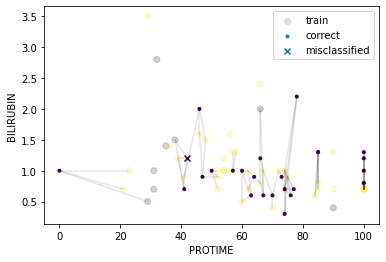

<Figure size 432x288 with 0 Axes>

In [ ]:
### running KNN on hep_df for top 2 RF important features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
hep_df2 = hep_df[[hep_top_feat_RF, hep_sec_feat_RF, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2 = train_test_split(hep_df2)
x_all_hep2 = hep_df2.iloc[:, :-1].to_numpy()
y_all_hep2 = hep_df2.iloc[:, -1].to_numpy()

# runs KNN
acc = run_KNN(x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2, [hep_top_feat_RF, hep_sec_feat_RF], filename = 'hep_KNN_impo')

The accuracy of the model on the training data: 77.9%
The accuracy of the model on the testing data: 54.55%


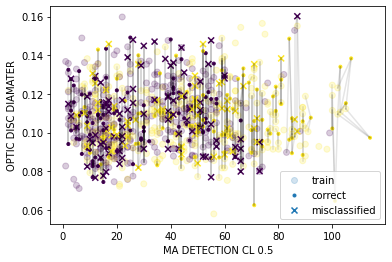

<Figure size 432x288 with 0 Axes>

In [ ]:
### running KNN on mess_df data for top 2 RF important features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
mess_df2 = mess_df[[mess_top_feat_RF, mess_sec_feat_RF, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2 = train_test_split(mess_df2)
x_all_mess2 = mess_df2.iloc[:, :-1].to_numpy()
y_all_mess2 = mess_df2.iloc[:, -1].to_numpy()
# runs KNN
acc = run_KNN(x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2, [mess_top_feat_RF, mess_sec_feat_RF], filename = 'mess_KNN_impo')

### Visualizing KNN by plotting the model on most correlated features

The accuracy of the model on the training data: 89.58%
The accuracy of the model on the testing data: 92.31%


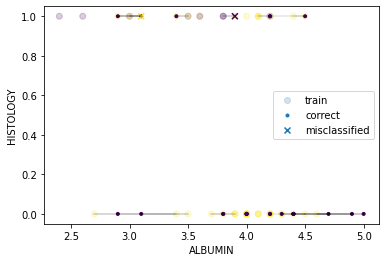

<Figure size 432x288 with 0 Axes>

In [ ]:
### running KNN on hep_df for top 2 correlated features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
hep_df2c = hep_df[[hep_most_pos_cor, hep_most_neg_cor, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_hep2c, x_test_hep2c, y_train_hep2c, y_test_hep2c = train_test_split(hep_df2c)

x_all_df2c = hep_df2c.iloc[:, :-1].to_numpy()
y_all_df2c = hep_df2c.iloc[:, -1].to_numpy()

# runs KNN
acc = run_KNN(x_train_hep2c, x_test_hep2c, y_train_hep2c, y_test_hep2c, [hep_most_pos_cor, hep_most_neg_cor], filename = 'hep_KNN_corr')

The accuracy of the model on the training data: 80.56%
The accuracy of the model on the testing data: 52.12%


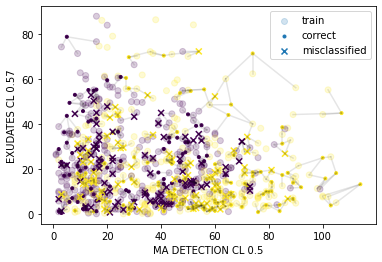

<Figure size 432x288 with 0 Axes>

In [ ]:
### running KNN on mess_df data for top 2 correlated features

# splits the hep_df dataframe to only include the columns with the top 2 correlated
# features and the target labels
mess_df2c = mess_df[[mess_most_pos_cor, mess_most_neg_cor, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c = train_test_split(mess_df2c)

# runs KNN
acc = run_KNN(x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c, [mess_most_pos_cor, mess_most_neg_cor], filename = 'mess_KNN_corr')

### Testing different values for K

The accuracy of the model on the training data: 91.49%
The accuracy of the model on the testing data: 86.67%

Best K value = 5



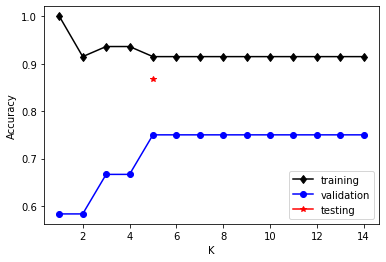

In [ ]:
x = hep_df.iloc[:, :-1].to_numpy()
y = hep_df.iloc[:, -1].to_numpy()

test = test_diff_K(x, y, filename = 'hep_KNN_best_k')

The accuracy of the model on the training data: 70.76%
The accuracy of the model on the testing data: 68.04%

Best K value = 12



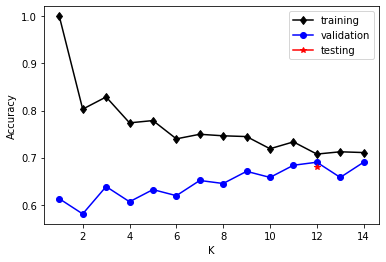

In [ ]:
x = mess_df.iloc[:, :-1].to_numpy()
y = mess_df.iloc[:, -1].to_numpy()

test = test_diff_K(x, y, filename = 'mess_KNN_best_k')

### Using different distance functions

In [ ]:
# functions = array of function objects
# function_strings = array of the function names as strings
# k_values = array of k values
def test_distances(functions, function_strings, k_values, x_train, x_test, y_train, y_test):
  for index in range(len(functions)):
    d_function = functions[index]
    function_string = function_strings[index]
    print("Testing " + function_string + " distance function:")

    for k in k_values:
      accuracy, train_accuracy = run_KNN(x_train, x_test, y_train, y_test, K_val = k, function = d_function, silent = True)

      print("\tk = " + str(k))
      print("\tModel accuracy on training data: " + str(round(train_accuracy * 100, 2)) + "%")
      print("\tModel accuracy on testing data: " + str(round(accuracy * 100, 2)) + "%")
      print("")

In [ ]:
### on hep_df

functions = [euclidean, manhattan, cosine]
function_strings = ['euclidean', 'manhattan', 'cosine']
k_values = [1, 3, 5]

test_distances(functions, function_strings, k_values, x_train_hep, x_test_hep, y_train_hep, y_test_hep)

Testing euclidean distance function:
	k = 1
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 84.62%

	k = 3
	Model accuracy on training data: 85.42%
	Model accuracy on testing data: 88.46%

	k = 5
	Model accuracy on training data: 85.42%
	Model accuracy on testing data: 92.31%

Testing manhattan distance function:
	k = 1
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 84.62%

	k = 3
	Model accuracy on training data: 89.58%
	Model accuracy on testing data: 88.46%

	k = 5
	Model accuracy on training data: 85.42%
	Model accuracy on testing data: 88.46%

Testing cosine distance function:
	k = 1
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 88.46%

	k = 3
	Model accuracy on training data: 87.5%
	Model accuracy on testing data: 92.31%

	k = 5
	Model accuracy on training data: 85.42%
	Model accuracy on testing data: 96.15%



In [ ]:
### on mess_df

functions = [euclidean, manhattan, cosine]
function_strings = ['euclidean', 'manhattan', 'cosine']
k_values = [1, 3, 5]

test_distances(functions, function_strings, k_values, x_train_mess, x_test_mess, y_train_mess, y_test_mess)

Testing euclidean distance function:
	k = 1
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 59.7%

	k = 3
	Model accuracy on training data: 82.45%
	Model accuracy on testing data: 62.73%

	k = 5
	Model accuracy on training data: 77.12%
	Model accuracy on testing data: 64.55%

Testing manhattan distance function:
	k = 1
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 61.21%

	k = 3
	Model accuracy on training data: 80.72%
	Model accuracy on testing data: 63.94%

	k = 5
	Model accuracy on training data: 78.06%
	Model accuracy on testing data: 63.64%

Testing cosine distance function:
	k = 1
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 63.33%

	k = 3
	Model accuracy on training data: 82.13%
	Model accuracy on testing data: 63.94%

	k = 5
	Model accuracy on training data: 77.12%
	Model accuracy on testing data: 66.06%



### Feature Importance

For feature importance we will employ a simple approach. We will first train a model using a training set. We will then use that model predict the labels of the training set. Afterwards we can fit a random forest (could be linear regression as well) model on the training input and the predicted output. From there we can extract the importances of this new model to see how the original model weighs the importance of each individual to make its prediction.
Essentially
$$knn.fit(x_{train}, y_{train}).predict(x_{train}) = \hat y, \space importance = RandomForest.fit(x_{train}, \hat y).featureImportances$$

In [ ]:
# we use k! = 1, otherwise y_pred = y
def knn_feat_importance(x_train, y_train, df):
  knn_model = KNN(3)
  knn_model = knn_model.fit(x_train, y_train)

  class_prob, _ = knn_model.predict(x_train)
  class_pred = np.argmax(class_prob, axis = -1)

  feat_arr = RF_find_features(x_train, class_pred, df)

  return feat_arr

Feature: AGE                           Score: 0.067736    
Feature: SEX                           Score: 0.003563    
Feature: STEROID                       Score: 0.002226    
Feature: ANTIVIRALS                    Score: 0.006700    
Feature: FATIGUE                       Score: 0.000000    
Feature: MALAISE                       Score: 0.000000    
Feature: ANOREXIA                      Score: 0.058921    
Feature: LIVER BIG                     Score: 0.000000    
Feature: LIVER FIRM                    Score: 0.007094    
Feature: SPLEEN PALPABLE               Score: 0.024861    
Feature: SPIDERS                       Score: 0.003551    
Feature: ASCITES                       Score: 0.012331    
Feature: VARICES                       Score: 0.004165    
Feature: BILIRUBIN                     Score: 0.049859    
Feature: ALK PHOSPHATE                 Score: 0.028965    
Feature: SGOT                          Score: 0.046450    
Feature: ALBUMIN                       Score: 0.159958  

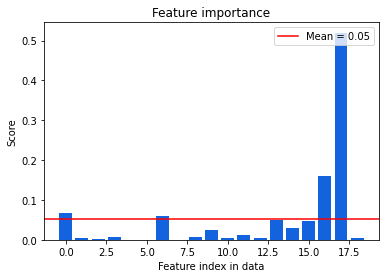

In [ ]:
# finding important features for hep_df

knn_hep_feat_importance_arr = knn_feat_importance(x_train_hep, y_train_hep, hep_df)
plot_feature_importance(knn_hep_feat_importance_arr)

In [ ]:
# printing important features for hep_df

knn_hep_sorted_feature_names, knn_hep_sorted_feature_values = find_top_features(knn_hep_feat_importance_arr, hep_df)

knn_hep_top_feat_RF = knn_hep_sorted_feature_names[0]
knn_hep_sec_feat_RF_RF = knn_hep_sorted_feature_names[1]

print("The most important feature is " + knn_hep_top_feat_RF)
print("The second most important feature is " + knn_hep_sec_feat_RF_RF)

The most important feature is PROTIME
The second most important feature is ALBUMIN


The accuracy of the model on the training data: 89.58%
The accuracy of the model on the testing data: 96.15%


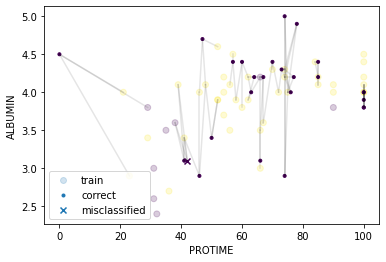

In [ ]:
### running KNN on hep_df data for top 2 important features based on the above calculations

# splits the mess_df dataframe to only include the columns with the top 2
# features and the target labels
knn_hep_df = hep_df[[knn_hep_top_feat_RF, knn_hep_sec_feat_RF_RF, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_knn_hep, x_test_knn_hep, y_train_knn_hep, y_test_knn_hep = train_test_split(knn_hep_df)
x_all_knn_hep = knn_hep_df.iloc[:, :-1].to_numpy()
y_all_knn_hep = knn_hep_df.iloc[:, -1].to_numpy()

# runs KNN
acc = run_KNN(x_train_knn_hep, x_test_knn_hep, y_train_knn_hep, y_test_knn_hep, [knn_hep_top_feat_RF, knn_hep_sec_feat_RF_RF])

Feature: QUALITY ASSESSMENT            Score: 0.000000    
Feature: PRE-SCREENING                 Score: 0.000000    
Feature: MA DETECTION CL 0.5           Score: 0.184221    
Feature: MA DETECTION CL 0.6           Score: 0.028804    
Feature: MA DETECTION CL 0.7           Score: 0.023769    
Feature: MA DETECTION CL 0.8           Score: 0.031845    
Feature: MA DETECTION CL 0.9           Score: 0.031176    
Feature: MA DETECTION CL 1.0           Score: 0.055161    
Feature: EXUDATES CL 0.5               Score: 0.139269    
Feature: EXUDATES CL 0.57              Score: 0.102605    
Feature: EXUDATES CL 0.64              Score: 0.066616    
Feature: EXUDATES CL 0.71              Score: 0.051966    
Feature: EXUDATES CL 0.79              Score: 0.026622    
Feature: EXUDATES CL 0.86              Score: 0.022510    
Feature: EXUDATES CL 0.93              Score: 0.058655    
Feature: EXUDATES CL 1.00              Score: 0.019165    
Feature: MACULA-OPTIC DISC DISTANCE    Score: 0.072798  

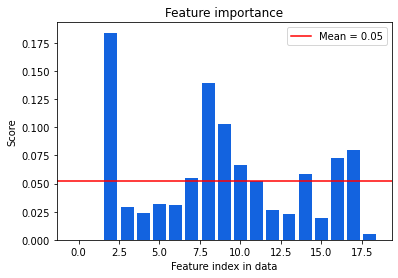

In [ ]:
# finding important features for mess_df

knn_mess_feat_importance_arr = knn_feat_importance(x_train_mess, y_train_mess, mess_df)
plot_feature_importance(knn_mess_feat_importance_arr)

In [ ]:
# printing important features for mess_df

knn_mess_sorted_feature_names, knn_mess_sorted_feature_values = find_top_features(knn_mess_feat_importance_arr, mess_df)

knn_mess_top_feat_RF = knn_mess_sorted_feature_names[0]
knn_mess_sec_feat_RF = knn_mess_sorted_feature_names[1]

print("The most important feature is " + knn_mess_top_feat_RF)
print("The second most important feature is " + knn_mess_sec_feat_RF)

The most important feature is MA DETECTION CL 0.5
The second most important feature is EXUDATES CL 0.5


The accuracy of the model on the training data: 78.84%
The accuracy of the model on the testing data: 62.12%


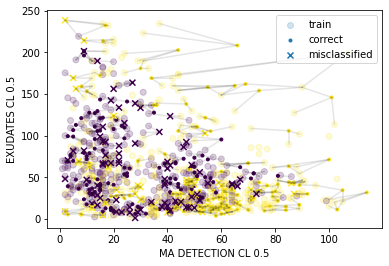

In [ ]:
### running KNN on mess_df data for top 2 important features based on the above calculations

# splits the mess_df dataframe to only include the columns with the top 2
# features and the target labels
knn_mess_df = mess_df[[knn_mess_top_feat_RF, knn_mess_sec_feat_RF, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_knn_mess, x_test_knn_mess, y_train_knn_mess, y_test_knn_mess = train_test_split(knn_mess_df)

x_all_knn_mess = knn_mess_df.iloc[:, :-1].to_numpy()
y_all_knn_mess = knn_mess_df.iloc[:, -1].to_numpy()

# runs KNN
acc = run_KNN(x_train_knn_mess, x_test_knn_mess, y_train_knn_mess, y_test_knn_mess, feature_names = [knn_mess_top_feat_RF, knn_mess_sec_feat_RF])

### Decision boundaries

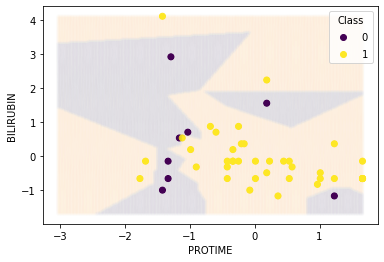

In [ ]:
### plotting the decision boundary for KNN on hep_df for the top 2 important RF features

# standardizes the data for easier plotting
x_all_hep2_stan = standardize_2D_array(x_all_hep2.transpose()).transpose()
x_train_hep2_stan = standardize_2D_array(x_train_hep2.transpose()).transpose()
x_test_hep2_stan = standardize_2D_array(x_test_hep2.transpose()).transpose()

# plots the decision boundary
plot_KNN_DB(x_all_hep2_stan, y_all_hep2, x_train_hep2_stan, x_test_hep2_stan, y_train_hep2, y_test_hep2, [hep_top_feat_RF, hep_sec_feat_RF], 'knn_hep_DB')

# recall: we already ran KNN on this data; the accuracy was 89.58% on training
# and 96.15% on testing

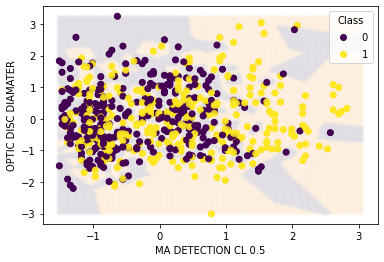

In [ ]:
### plotting the decision boundary for KNN on hep_df for the top 2 important RF features

# standardizes the data for easier plotting
x_all_mess2_stan = standardize_2D_array(x_all_mess2.transpose()).transpose()
x_train_mess2_stan = standardize_2D_array(x_train_mess2.transpose()).transpose()
x_test_mess2_stan = standardize_2D_array(x_test_mess2.transpose()).transpose()

# plots the decision boundary
plot_KNN_DB(x_all_mess2_stan, y_all_mess2, x_train_mess2_stan, x_test_mess2_stan, y_train_mess2, y_test_mess2, [mess_top_feat_RF, mess_sec_feat_RF], 'knn_mess_DB')

# recall: we already ran KNN on this data; the accuracy was 77.9% on training
# and 54.55% on testing


## DT experiments

### Baseline accuracy tests


In [ ]:
### running DT on all hep_df data

acc = run_DT(x_train_hep, x_test_hep, y_train_hep, y_test_hep, hep_df)

The accuracy of the model on the training data: 95.83%
The accuracy of the model on the testing data: 88.46%


In [ ]:
### running DT on all mess_df data

acc = run_DT(x_train_mess, x_test_mess, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 69.44%
The accuracy of the model on the testing data: 62.42%


### Accuracy tests on normalized data

In [ ]:
### running DT on all normalized hep_df data

acc = run_DT(x_train_hep_norm, x_test_hep_norm, y_train_hep, y_test_hep)

The accuracy of the model on the training data: 95.83%
The accuracy of the model on the testing data: 65.38%


In [ ]:
### running DT on all normalized mess_df data

acc = run_DT(x_train_mess_norm, x_test_mess_norm, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 69.44%
The accuracy of the model on the testing data: 61.82%


### Accuracy tests on standardized data

In [ ]:
### running DT on all standardized hep_df data

acc = run_DT(x_train_hep_stan, x_test_hep_stan, y_train_hep, y_test_hep)

The accuracy of the model on the training data: 95.83%
The accuracy of the model on the testing data: 84.62%


In [ ]:
### running DT on all standardized mess_df data

acc = run_DT(x_train_mess_stan, x_test_mess_stan, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 69.44%
The accuracy of the model on the testing data: 64.24%


### Accuracy tests on imputated data

In [ ]:
### running DT on all hep_df data cleaned through imputation
acc = run_DT(x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp, hep_imp_df)

The accuracy of the model on the training data: 92.63%
The accuracy of the model on the testing data: 84.0%


### Visualizing DT by plotting the model on most important RF features

The accuracy of the model on the training data: 95.83%
The accuracy of the model on the testing data: 96.15%


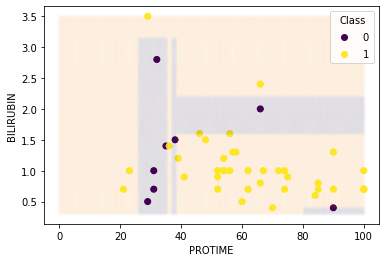

In [ ]:
### running DT on hep_df for top 2 RF important features
x_all_hep2 = hep_df2.iloc[:, :-1].to_numpy()
y_all_hep2 = hep_df2.iloc[:, -1].to_numpy()

acc = run_DT(x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2, x = x_all_hep2, y = y_all_hep2, feature_names = [hep_top_feat_RF, hep_sec_feat_RF], filename = 'hep_DT_impo')

The accuracy of the model on the training data: 64.11%
The accuracy of the model on the testing data: 58.79%


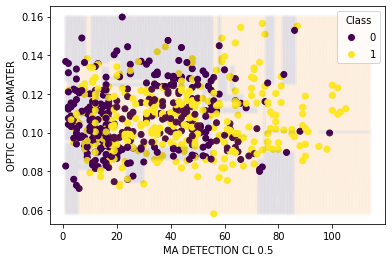

In [ ]:
### running DT on mess_df data for top 2 RF important features

x_all_mess2 = mess_df2.iloc[:, :-1].to_numpy()
y_all_mess2 = mess_df2.iloc[:, -1].to_numpy()

# runs DT
acc = run_DT(x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2, x = x_all_mess2, y = y_all_mess2, feature_names = [mess_top_feat_RF, mess_sec_feat_RF])

### Visualizing DT by plotting the model on most correlated features

The accuracy of the model on the training data: 87.5%
The accuracy of the model on the testing data: 96.15%


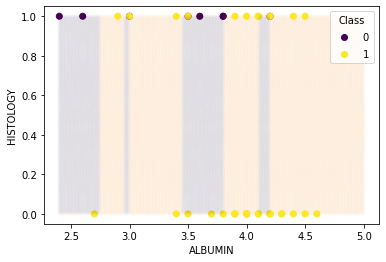

In [ ]:
### running DT on hep_df for top 2 correlated features
x_all_hep2c = hep_df2c.iloc[:, :-1].to_numpy()
y_all_hep2c = hep_df2c.iloc[:, -1].to_numpy()

acc = run_DT(x_train_hep2c, x_test_hep2c, y_train_hep2c, y_test_hep2c, x = x_all_hep2c, y = y_all_hep2c, feature_names = [hep_most_pos_cor, hep_most_neg_cor], filename = 'hep_DT_corr')

The accuracy of the model on the training data: 65.05%
The accuracy of the model on the testing data: 60.91%


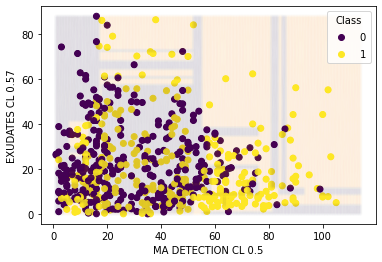

In [ ]:
### running DT on mess_df data for top 2 correlated features

x_all_mess2c = mess_df2c.iloc[:, :-1].to_numpy()
y_all_mess2c = mess_df2c.iloc[:, -1].to_numpy()

# runs DT
acc = run_DT(x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c, x = x_all_mess2c, y = y_all_mess2c, feature_names = [mess_most_pos_cor, mess_most_neg_cor])

### Testing different depth values

The accuracy of the model on the training data: 93.62%
The accuracy of the model on the testing data: 86.67%

Best depth = 1



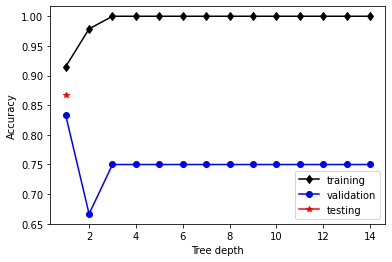

In [ ]:
### testing for the best depth value on hep_df

x_all_hep = hep_df.iloc[:, :-1].to_numpy()
y_all_hep = hep_df.iloc[:, -1].to_numpy()

test = test_diff_depth(x_all_hep, y_all_hep, filename = 'hep_DT_best_depth')

The accuracy of the model on the training data: 83.2%
The accuracy of the model on the testing data: 65.98%

Best depth = 10



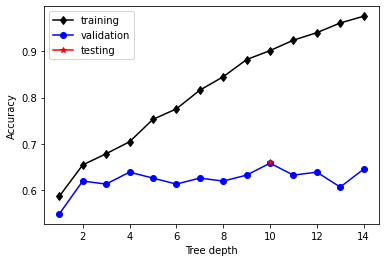

In [ ]:
### testing for the best depth value on mess_df

x_all_mess = mess_df.iloc[:, :-1].to_numpy()
y_all_mess = mess_df.iloc[:, -1].to_numpy()

test = test_diff_depth(x_all_mess, y_all_mess, filename = 'mess_DT_best_depth')

### Using different cost functions

In [ ]:
def test_costs(arr_costFun, arr_maxDepth, x_train, x_test, y_train, y_test):
  function_name = re.compile(r'(?<=<function )(.*)(?=_cost)')
  
  for index in range(len(arr_costFun)):
    if arr_costFun[index] in [misclassification_cost, gini_cost, entropy_cost]:
      fun = arr_costFun[index]
      name = function_name.search(str(fun))

      print("Testing for " + name.group() + " cost function")

      for maxDepth in arr_maxDepth:
        accuracy, train_accuracy = run_DT(x_train, x_test, y_train, y_test, depth = maxDepth, function = fun, silent = True)
      
        print("\tdepth = " + str(maxDepth))
        print("\tModel accuracy on training data: " + str(round(train_accuracy * 100, 2)) + "%")
        print("\tModel accuracy on testing data: " + str(round(accuracy * 100, 2)) + "%")
        print("")

In [ ]:
### on hep_df

functions = [misclassification_cost, gini_cost, entropy_cost]
depth_values = [1, 2, 3, 4, 5]

test_costs(functions, depth_values, x_train_hep, x_test_hep, y_train_hep, y_test_hep)

Testing for misclassification cost function
	depth = 1
	Model accuracy on training data: 87.5%
	Model accuracy on testing data: 92.31%

	depth = 2
	Model accuracy on training data: 93.75%
	Model accuracy on testing data: 92.31%

	depth = 3
	Model accuracy on training data: 95.83%
	Model accuracy on testing data: 88.46%

	depth = 4
	Model accuracy on training data: 97.92%
	Model accuracy on testing data: 92.31%

	depth = 5
	Model accuracy on training data: 97.92%
	Model accuracy on testing data: 92.31%

Testing for gini cost function
	depth = 1
	Model accuracy on training data: 87.5%
	Model accuracy on testing data: 92.31%

	depth = 2
	Model accuracy on training data: 95.83%
	Model accuracy on testing data: 92.31%

	depth = 3
	Model accuracy on training data: 97.92%
	Model accuracy on testing data: 84.62%

	depth = 4
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 88.46%

	depth = 5
	Model accuracy on training data: 100.0%
	Model accuracy on testing data: 88.46

In [ ]:
### on mess_df

test_costs(functions, depth_values, x_train_mess, x_test_mess, y_train_mess, y_test_mess)

Testing for misclassification cost function
	depth = 1
	Model accuracy on training data: 62.7%
	Model accuracy on testing data: 58.48%

	depth = 2
	Model accuracy on training data: 67.24%
	Model accuracy on testing data: 61.21%

	depth = 3
	Model accuracy on training data: 69.44%
	Model accuracy on testing data: 62.42%

	depth = 4
	Model accuracy on training data: 71.63%
	Model accuracy on testing data: 61.82%

	depth = 5
	Model accuracy on training data: 73.67%
	Model accuracy on testing data: 61.21%

Testing for gini cost function
	depth = 1
	Model accuracy on training data: 62.7%
	Model accuracy on testing data: 58.48%

	depth = 2
	Model accuracy on training data: 66.93%
	Model accuracy on testing data: 61.52%

	depth = 3
	Model accuracy on training data: 68.81%
	Model accuracy on testing data: 63.03%

	depth = 4
	Model accuracy on training data: 71.0%
	Model accuracy on testing data: 63.03%

	depth = 5
	Model accuracy on training data: 72.57%
	Model accuracy on testing data: 63.64%

### Feature Importance

For feature importance we will employ a simple approach. We will first train a model using a training set. We will then use that model to predict the labels of the training set. Afterwards, we can fit a random forest (could be linear regression as well) model on the training input and the predicted output. From there we can extract the importances of this new model to see how the original model weighs the importance of each individual to make its prediction.
Essentially
$$dt.fit(x_{train}, y_{train}).predict(x_{train}) = \hat y, \space importance = RandomForest.fit(x_{train}, \hat y).featureImportances$$

In [ ]:
def dt_feat_importance(x_train, y_train, df):
  dt_model = DecisionTree(max_depth = 10, cost_fn = gini_cost)
  dt_model = dt_model.fit(x_train, y_train)

  class_prob = dt_model.predict(x_train)
  class_pred = np.argmax(class_prob, axis = -1)

  feat_arr = RF_find_features(x_train, class_pred, df)

  return feat_arr

Feature: AGE                           Score: 0.054532    
Feature: SEX                           Score: 0.013428    
Feature: STEROID                       Score: 0.001468    
Feature: ANTIVIRALS                    Score: 0.000000    
Feature: FATIGUE                       Score: 0.003242    
Feature: MALAISE                       Score: 0.005091    
Feature: ANOREXIA                      Score: 0.020290    
Feature: LIVER BIG                     Score: 0.008696    
Feature: LIVER FIRM                    Score: 0.003202    
Feature: SPLEEN PALPABLE               Score: 0.006426    
Feature: SPIDERS                       Score: 0.016832    
Feature: ASCITES                       Score: 0.022819    
Feature: VARICES                       Score: 0.013162    
Feature: BILIRUBIN                     Score: 0.132432    
Feature: ALK PHOSPHATE                 Score: 0.114346    
Feature: SGOT                          Score: 0.051750    
Feature: ALBUMIN                       Score: 0.103891  

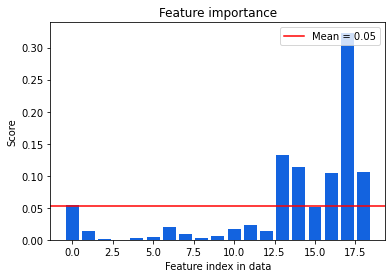

In [ ]:
# finding important features for hep_df

dt_hep_importance_arr = dt_feat_importance(x_train_hep, y_train_hep, hep_df)
plot_feature_importance(dt_hep_importance_arr)

In [ ]:
### printing the top 2 important features for hep_df

dt_hep_sorted_feature_names, dt_hep_sorted_feature_values = find_top_features(dt_hep_importance_arr, hep_df)

dt_hep_top_feat_RF = dt_hep_sorted_feature_names[0]
dt_hep_sec_feat_RF_RF = dt_hep_sorted_feature_names[1]

print("The most important feature is " + dt_hep_top_feat_RF)
print("The second most important feature is " + dt_hep_sec_feat_RF_RF)

The most important feature is PROTIME
The second most important feature is BILIRUBIN


The accuracy of the model on the training data: 95.83%
The accuracy of the model on the testing data: 96.15%


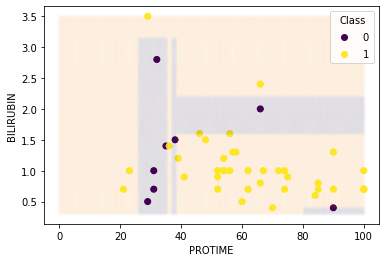

In [ ]:
### running DT on hep_df data for top 2 important features based on the above calculations

# splits the mess_df dataframe to only include the columns with the top 2
# features and the target labels
hep_df4 = hep_df[[dt_hep_top_feat_RF, dt_hep_sec_feat_RF_RF, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_hep4, x_test_hep4, y_train_hep4, y_test_hep4 = train_test_split(hep_df4)

x_all_df4 = hep_df4.iloc[:, :-1].to_numpy()
y_all_df4 = hep_df4.iloc[:, -1].to_numpy()

# runs KNN
acc = run_DT(x_train_hep4, x_test_hep4, y_train_hep4, y_test_hep4, x = x_all_df4, y = y_all_df4, feature_names = [dt_hep_top_feat_RF, dt_hep_sec_feat_RF_RF])

Feature: QUALITY ASSESSMENT            Score: 0.000000    
Feature: PRE-SCREENING                 Score: 0.000000    
Feature: MA DETECTION CL 0.5           Score: 0.200474    
Feature: MA DETECTION CL 0.6           Score: 0.027010    
Feature: MA DETECTION CL 0.7           Score: 0.020463    
Feature: MA DETECTION CL 0.8           Score: 0.028125    
Feature: MA DETECTION CL 0.9           Score: 0.037264    
Feature: MA DETECTION CL 1.0           Score: 0.040410    
Feature: EXUDATES CL 0.5               Score: 0.096782    
Feature: EXUDATES CL 0.57              Score: 0.083443    
Feature: EXUDATES CL 0.64              Score: 0.060020    
Feature: EXUDATES CL 0.71              Score: 0.068542    
Feature: EXUDATES CL 0.79              Score: 0.033174    
Feature: EXUDATES CL 0.86              Score: 0.023834    
Feature: EXUDATES CL 0.93              Score: 0.102700    
Feature: EXUDATES CL 1.00              Score: 0.018417    
Feature: MACULA-OPTIC DISC DISTANCE    Score: 0.075983  

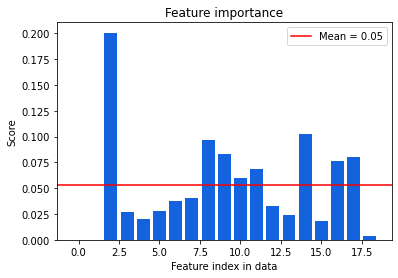

In [ ]:
#### finding important features for mess_df

dt_mess_importance_arr = dt_feat_importance(x_train_mess, y_train_mess, mess_df)
plot_feature_importance(dt_mess_importance_arr)

In [ ]:
### printing the top 2 important features for mess_df

dt_mess_sorted_feature_names, dt_mess_sorted_feature_values = find_top_features(dt_mess_importance_arr, mess_df)

dt_mess_top_feat_RF = dt_mess_sorted_feature_names[0]
dt_mess_sec_feat_RF = dt_mess_sorted_feature_names[1]

print("The most important feature is " + dt_mess_top_feat_RF)
print("The second most important feature is " + dt_mess_sec_feat_RF)

The most important feature is MA DETECTION CL 0.5
The second most important feature is EXUDATES CL 0.93


The accuracy of the model on the training data: 67.08%
The accuracy of the model on the testing data: 60.91%


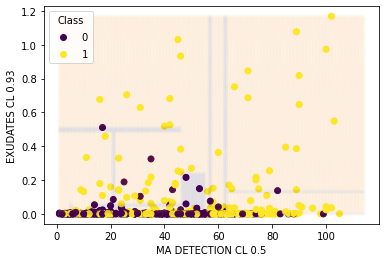

In [ ]:
### running DT on mess_df data for top 2 important features based on the above calculations

# splits the mess_df dataframe to only include the columns with the top 2
# features and the target labels
mess_df4 = mess_df[[dt_mess_top_feat_RF, dt_mess_sec_feat_RF, 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess4, x_test_mess4, y_train_mess4, y_test_mess4 = train_test_split(mess_df4)

x_all_mess4 = mess_df4.iloc[:, :-1].to_numpy()
y_all_mess4 = mess_df4.iloc[:, -1].to_numpy()

# runs KNN
acc = run_DT(x_train_mess4, x_test_mess4, y_train_mess4, y_test_mess4, x = x_all_mess4, y = y_all_mess4, feature_names = [dt_mess_top_feat_RF, dt_mess_sec_feat_RF])

### Decision boundaries

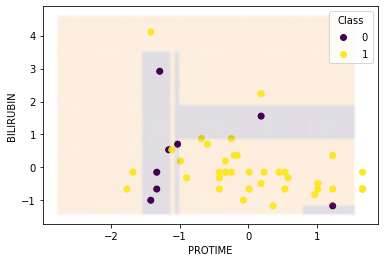

In [ ]:
### plotting the decision boundary for DT on hep_df for the top 2 important RF features

plot_DT_DB(x_all_hep2_stan, y_all_hep2, x_train_hep2_stan, x_test_hep2_stan, y_train_hep2, y_test_hep2, [hep_top_feat_RF, hep_sec_feat_RF], 'hep_DT_DB')

# recall: we already ran DT on this data; the accuracy was 95.83% on training
# and 96.15% on testing

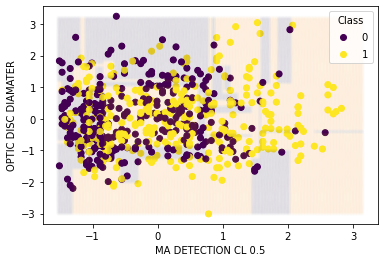

In [ ]:
### plotting the decision boundary for DT on mess_df for the top 2 important RF features

plot_DT_DB(x_all_mess2_stan, y_all_mess2, x_train_mess2_stan, x_test_mess2_stan, y_train_mess2, y_test_mess2, [mess_top_feat_RF, mess_sec_feat_RF], 'mess_DT_DB')

# recall: we already ran DT on this data; the accuracy was 64.11% on training
# and 58.79% on testing